### Importing the libraries

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from diffusers import DPMSolverMultistepScheduler, UNet2DModel, DDPMScheduler, AutoencoderKL
import pandas as pd
from PIL import Image
import os
from matplotlib import pyplot as plt
from dotenv import load_dotenv
import time
import logging

/home/asardesai/Projects/Causal-Diffusion-Model/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup the logger
load_dotenv()
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("visualize.log"),  # Log to file
        logging.StreamHandler()          # Log to console
    ],
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger.setLevel(os.getenv('LOG_LEVEL'))
logger.info(os.getenv('LOG_LEVEL'))


2025-03-23 14:04:34 - INFO - DEBUG


### Class Definitions

In [3]:
class AnnotationReader:
    '''Reads the Labels and maintains them in memory'''
    def __init__(self, filename):
        data = []
        indices = []
        with open(filename, 'r') as file:
            n_lines = int(file.readline())
            self.features = file.readline().split()
            for i in range(n_lines):
                line = file.readline().split()
                indices.append(line[0])
                data.append(line[1:])
        self.dataframe = pd.DataFrame(data, columns=self.features, index=indices)
    
    def __getitem__(self, idx):
        return self.dataframe.index[idx], self.dataframe.iloc[idx].to_dict()
    
    def __len__(self):
        return len(self.dataframe)

In [4]:
class CustomImageDataset(datasets.VisionDataset):
    '''Dataset that returns the image tensor and labels. Loads them from disk.'''
    def __init__(self, image_dir, annotation_file, transform=None):
        self.annotations = AnnotationReader(annotation_file)
        self.image_dir = image_dir
        self.transform = transform
        super().__init__(image_dir, transform=transform)

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_file, labels = self.annotations.__getitem__(idx)
        img_tensor = self.transform(Image.open(os.path.join(self.image_dir, img_file)).convert("RGB"))
        return img_tensor, labels

In [5]:
class AutoencoderWrapper:
    '''Inference wrapper for Autoencoder used in encoding and decoding image to Latent space'''

    def __init__(self, DEVICE):
        self.vae = AutoencoderKL.from_pretrained("sd-vae-ft-mse/", torch_dtype=torch.float32)
        self.vae.to(DEVICE)
        self.vae.eval()
    
    def encode(self, img_batch):
        with torch.no_grad():
            return self.vae.encode(img_batch).latent_dist.sample()

    def decode(self, latent_img_batch):
        with torch.no_grad():
            return self.vae.decode(latent_img_batch).sample

In [6]:
def visualize_image(image_tensor):
    '''Allows us to visualize an image tensor'''
    to_pil = ToPILImage()
    image_pil = to_pil(image_tensor)
    # image_pil.thumbnail((128,128))
    return image_pil

### Hyperparameters

In [7]:
BATCH_SIZE = int(os.getenv('BATCH_SIZE'))
NUM_EPOCHS = int(os.getenv('NUM_EPOCHS'))
MODEL_PATH = 'model.pt'
DEVICE_NAME = os.getenv('DEVICE')
DEVICE = torch.device(DEVICE_NAME) if torch.cuda.is_available() else 'cpu'
IMAGE_RESOLUTION = 256 # Dimensions of image to be passed into VAE
LATENT_SPACE_RESOLUTION = IMAGE_RESOLUTION / 8 # Size of the latent space
LATENT_SPACE_CHANNELS = 4 # Channel dimension of latent space

### Initialize the DataLoader

2025-03-23 14:04:47 - INFO - torch.Size([3, 256, 256])
2025-03-23 14:04:47 - INFO - {'5_o_Clock_Shadow': '1', 'Arched_Eyebrows': '1', 'Attractive': '-1', 'Bags_Under_Eyes': '-1', 'Bald': '-1', 'Bangs': '-1', 'Big_Lips': '1', 'Big_Nose': '1', 'Black_Hair': '-1', 'Blond_Hair': '-1', 'Blurry': '-1', 'Brown_Hair': '-1', 'Bushy_Eyebrows': '-1', 'Chubby': '1', 'Double_Chin': '1', 'Eyeglasses': '-1', 'Goatee': '1', 'Gray_Hair': '-1', 'Heavy_Makeup': '-1', 'High_Cheekbones': '1', 'Male': '1', 'Mouth_Slightly_Open': '-1', 'Mustache': '-1', 'Narrow_Eyes': '-1', 'No_Beard': '-1', 'Oval_Face': '1', 'Pale_Skin': '-1', 'Pointy_Nose': '-1', 'Receding_Hairline': '1', 'Rosy_Cheeks': '-1', 'Sideburns': '-1', 'Smiling': '-1', 'Straight_Hair': '-1', 'Wavy_Hair': '-1', 'Wearing_Earrings': '-1', 'Wearing_Hat': '-1', 'Wearing_Lipstick': '-1', 'Wearing_Necklace': '-1', 'Wearing_Necktie': '-1', 'Young': '-1'}


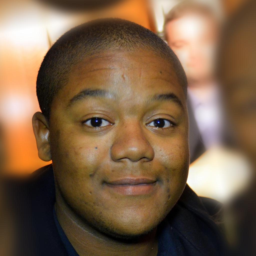

In [8]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_RESOLUTION),
    transforms.CenterCrop(IMAGE_RESOLUTION),
    transforms.ToTensor(),
])

# Instantiate Dataset Object
dataset = CustomImageDataset('CelebAMask-HQ/CelebA-HQ-img', 'CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt', transform=transform)
# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Test the dataset
img, labels = dataset.__getitem__(10)
logger.info(img.shape)
logger.info(labels)
visualize_image(img)



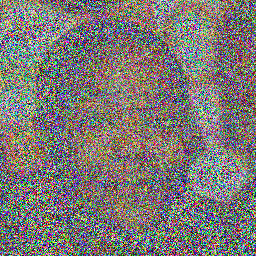

In [9]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
img2 = img.unsqueeze(0)
noise = torch.randn_like(img)
noisy_image = noise_scheduler.add_noise(img2, noise, torch.tensor([80]))
noisy_image = noisy_image[0]
visualize_image(noisy_image)

### Load and test the VAE

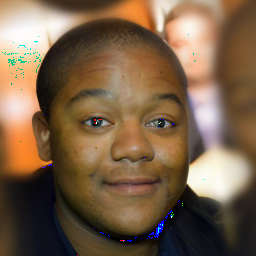

In [12]:
AE = AutoencoderWrapper(DEVICE)
latents = AE.encode(img.unsqueeze(0).to(DEVICE))
reconstructed_image = AE.decode(latents)
visualize_image(reconstructed_image.squeeze(0))

### Load the model 
Either from memory or instantiate it

In [13]:
# Create the network or load an existing one
if os.path.exists(MODEL_PATH):
    net = torch.load(MODEL_PATH, weights_only=False, map_location=DEVICE)
    logger.info("Loading model from checkpoint...")
else:
    net = UNet2DModel(
        sample_size=LATENT_SPACE_RESOLUTION,  # the target image resolution
        in_channels=LATENT_SPACE_CHANNELS,  # the number of input channels, 3 for RGB images
        out_channels=LATENT_SPACE_CHANNELS,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",  # a regular ResNet upsampling block
        ),
    )  # <<<
    logger.info("Initializing a new model...")
net.to(DEVICE)

2025-03-23 14:07:12 - INFO - Initializing a new model...


UNet2DModel(
  (conv_in): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

### Model Training

In [ ]:
# Train the model
net.train()

num_params = sum(p.numel() for p in net.parameters())
logger.info(f"Number of parameters: {num_params / 1e6:.2f} million")

# Our loss function
loss_fn = torch.nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(NUM_EPOCHS):
    if epoch % 10 == 0:
        torch.save(net, 'model.pt')
        logger.info('Saved the model checkpoint...')
    start_time = time.time()
    for x, y in dataloader:
        start_time = time.time()
        # Get some data and prepare the corrupted version
        x = x.to(DEVICE)  # Data on the GPU
        latent_x = AE.encode(x)
        noise_amount = torch.randn_like(latent_x).to(DEVICE)  # Pick random noise amounts
        timestep = torch.randint(0, 1000, (latent_x.shape[0],)).to(DEVICE) # Pick a random timestep to train on
        noisy_x = noise_scheduler.add_noise(latent_x, noise_amount, timestep) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, timestep).sample  # <<< Using timestep  always, adding .sample
        # Calculate the loss
        loss = loss_fn(pred, noise_amount)  # predicting
        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        # Store the loss for later
        losses.append(loss.item())
        logger.debug(f"Time it would take for an epoch is {(time.time() - start_time) * 30000 / 60 / BATCH_SIZE} minutes with batch size: {BATCH_SIZE}")
    end_time = time.time()
    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(dataloader) :]) / len(dataloader)
    logger.info(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}. Time taken to run epoch: {int((end_time-start_time)/60)} minutes.")


2025-03-23 14:11:31 - INFO - Number of parameters: 1.71 million
2025-03-23 14:11:31 - INFO - Saved the model checkpoint...
2025-03-23 14:11:32 - DEBUG - Time it would take for an epoch is 59.38251316547394 minutes with batch size: 8
2025-03-23 14:11:32 - DEBUG - Time it would take for an epoch is 16.953065991401672 minutes with batch size: 8
2025-03-23 14:11:33 - DEBUG - Time it would take for an epoch is 16.552940011024475 minutes with batch size: 8
2025-03-23 14:11:33 - DEBUG - Time it would take for an epoch is 16.55632257461548 minutes with batch size: 8
2025-03-23 14:11:33 - DEBUG - Time it would take for an epoch is 16.524702310562134 minutes with batch size: 8
2025-03-23 14:11:33 - DEBUG - Time it would take for an epoch is 16.652867197990417 minutes with batch size: 8
2025-03-23 14:11:34 - DEBUG - Time it would take for an epoch is 16.621127724647522 minutes with batch size: 8
2025-03-23 14:11:34 - DEBUG - Time it would take for an epoch is 16.11553132534027 minutes with batch 

In [ ]:
torch.save(net, 'model.pt')

### Evaluation

Try generating an image using the model

In [ ]:
net.eval()
# Create random noise
latents = torch.rand((1, LATENT_SPACE_CHANNELS, LATENT_SPACE_RESOLUTION, LATENT_SPACE_RESOLUTION)).to(DEVICE) * noise_scheduler.init_noise_sigma

# Sampling loop
noise_scheduler.set_timesteps(1000)  # Adjust steps as needed
for t in noise_scheduler.timesteps:
    with torch.no_grad():
        noise_pred = net(latents, t).sample  # Predict noise
    latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

# Decode from the latent space into the image space
pred_image = AE.decode(latents)
visualize_image(pred_image.squeeze().cpu())